In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

### Ramdomized input parameters

In [2]:
# Randomize 6 values from 10 to 23
arrival_rand = [random.randint(10, 23) for _ in range(6)]

# Randomize 6 values from 19 to 24 and 1 to 4
depart_rand = [random.randint(19, 24) if random.random() < 0.5 else random.randint(1, 4) for _ in range(6)]

# Randomize 6 values from 7 to 35
demand_rand = [random.randint(7, 35) for _ in range(6)]

print(arrival_rand)
print(depart_rand)
print(demand_rand)

[11, 23, 10, 10, 22, 17]
[22, 19, 24, 22, 3, 19]
[9, 29, 34, 32, 35, 30]


### Step 1: Load the arrival time, departure time, requested energy, power outputs

In [3]:
#Step 1: Load the arrival time, departure time, requested energy, power output
car = [1, 2, 3, 4, 5, 6]
arrival_time = [13, 14, 10, 23, 12, 13]
departure_time = [23, 16, 23, 4, 23, 3]
energy_requirement = [35, 30, 21, 17, 23, 28]
power_output = [3, 7, 11]

print(arrival_time)
print(departure_time)
print(energy_requirement)

[13, 14, 10, 23, 12, 13]
[23, 16, 23, 4, 23, 3]
[35, 30, 21, 17, 23, 28]


### Step 2: Load the ToUP tariffs from the energy service supplier

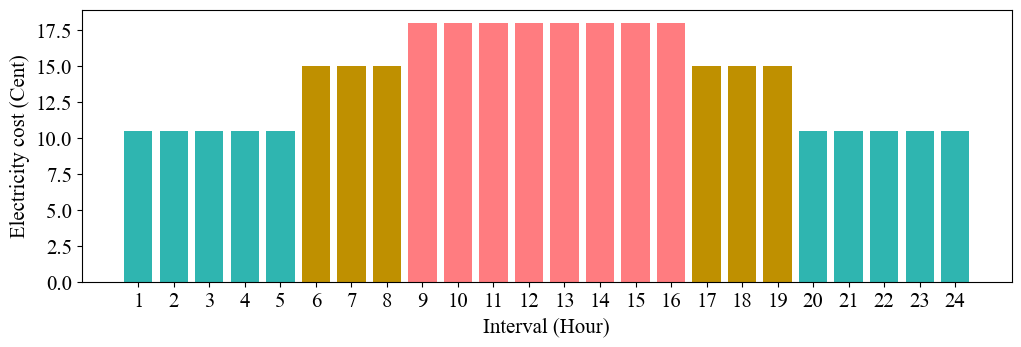

In [4]:
# Determine peak, shoulder and off-peak rates
time_list = list(range(1, 25))
off_rate = 10.5
shoulder_rate = 15
peak_rate = 18
hourly_tariff_list = []

hourly_tariff_list = [
    off_rate if (1 <= hour <= 5 or 20 <= hour <= 24)
    else shoulder_rate if (6 <= hour <= 8 or 17 <= hour <= 19)
    else peak_rate
    for hour in time_list
]


# Visualize tariff scheme
font = {'fontname': 'Times New Roman', 'size': 15 }

colors = ['#2FB5B0' if rate == off_rate else '#BF9000' if rate == shoulder_rate else '#FF7C80' for rate in hourly_tariff_list]
plt.figure(figsize=(12,4))
plt.subplots_adjust(bottom=0.2)  # Adjust the bottom margin for labels

plt.bar(time_list, hourly_tariff_list, color=colors)
plt.xlabel('Interval (Hour)', **font)
plt.ylabel("Electricity cost (Cent)",**font)
plt.xticks(time_list, **font)
plt.yticks(**font)

plt.savefig('24 hour tariff.png', dpi=700, bbox_inches='tight')


plt.show()



### Step 3: Determine power output and respective charge length

In [5]:
## Step 3.1: Generate vehicle's dwell time
dwell_time = [d - a if d > a else 24 + d - a for a, d in zip(arrival_time, departure_time)]

## Step 3.2: Generate charge duration corresponding to each power output
duration_by_mode = [[(e / p) for p in power_output] for e in energy_requirement] #Data type must be interger
 
## Step 3.3: Determine charging output

charge_power = [] 
charge_length = [] 
energy_fulfillment = []

# Identify vehicles, of which energy demand cannot be fulfiled within time constraint
high_demand_alert = ["Yes" if e > max(power_output)*dwell else "No" for e, dwell in zip(energy_requirement, dwell_time)]

#Prioritize slower charger as long as charge demand is fulfilled
for i, (time, dur) in enumerate(zip(dwell_time, duration_by_mode)):
    if high_demand_alert[i] == "No":
        for j in range(3):
            if dur[j] <= time:
                charge_power.append(power_output[j]) # select charge rate
                charge_length.append(int(dur[j])) # select the charge length
                energy_fulfillment.append(power_output[j]*int(dur[j]))
                break  # Break used to stop loop when the condition is met
    else:     
        charge_power.append(max(power_output))
        charge_length.append(dwell_time[i]) 
        energy_fulfillment.append(max(power_output)*dwell_time[i])
        print(f"Demand of car number {car[i]} cannot be met, maximum energy deliverable is {energy_fulfillment[i]} kWh")

print("Dwell time:", dwell_time)
print("Charge Power:", charge_power)
print("Charge Length:", charge_length)
print("Energy Fulfilment:", energy_fulfillment)
print("Energy Requirement:", energy_requirement)



Demand of car number 2 cannot be met, maximum energy deliverable is 22 kWh
Dwell time: [10, 2, 13, 5, 11, 14]
Charge Power: [7, 11, 3, 7, 3, 3]
Charge Length: [5, 2, 7, 2, 7, 9]
Energy Fulfilment: [35, 22, 21, 14, 21, 27]
Energy Requirement: [35, 30, 21, 17, 23, 28]


### Step 4, 5 & 6: Determine charging scenario, calculate charging costs and find optimal scenario

In [6]:
# Calculate % Energy Fulfillment
energy_fulfillment_percentage = [(ef / er) * 100 for ef, er in zip(energy_fulfillment, energy_requirement)]
energy_fulfillment_percentage = [round(ef, 0) for ef in energy_fulfillment_percentage]


In [7]:
charging_infor_list = list(zip(car, arrival_time, departure_time, charge_length, charge_power))

def find_optimal_charging_time(name, arrival, departure, charge_length, charge_power):
    
#Step 4: Determine the number of charging scenarios
    if departure > arrival: 
        scenario_num = departure - arrival - charge_length + 1
    else: 
        scenario_num = 24 + departure - arrival - charge_length + 1
        
    
#Step 5:  Calculate charging cost for each scenario.
    #Step 5.1: Determine start_end charging time
    
    start_time = [arrival + i - 1 for i in range(1,scenario_num + 1)]
    end_time = []
    
    for i in range(1, scenario_num + 1):
        if arrival - 1 + i + charge_length <= 24:
            end_time.append(arrival + i - 1 + charge_length)
        else: 
            end_time.append(arrival + i - 1 + charge_length - 24)
    

    #Step 5.2: Calculate charging cost for each scenario
    
    ## Select corresponding set of tariff:
    
    selected_hourly_tariff = []
    for i in range(scenario_num):
        if end_time[i] > start_time[i]: 
            list = hourly_tariff_list[start_time[i]:end_time[i]]  
        else: 
            list = hourly_tariff_list[start_time[i]:] + hourly_tariff_list[:end_time[i]] 
        selected_hourly_tariff.append(list)
    
        
    ## Calculate charging cost:
    charging_cost_scenario = []  
    for tariff_set in selected_hourly_tariff:
        session_cost = sum([charge_power*tariff for tariff in tariff_set])
        charging_cost_scenario.append(session_cost)
        
    start_time_and_charing_cost = dict(zip(start_time,charging_cost_scenario))

    
#Step 6: Find the minimum charging cost of all scenario and its respective charging start_end time
    optimal_index = charging_cost_scenario.index(min(charging_cost_scenario))
    optimal_start = start_time[optimal_index]
    optimal_end = end_time[optimal_index]
    
    optimal_cost = charging_cost_scenario[optimal_index] / 10
    optimal_start_end = optimal_start, optimal_end
    
    unscheduled_cost = charging_cost_scenario[0]/10
    unscheduled_start_end = start_time[0], end_time[0]
     
    return optimal_start_end, unscheduled_start_end, optimal_cost, unscheduled_cost






### Step 7: Assign the optimal charging starting time to the vehicle and report the charging cost

In [8]:

scheduled_start_end = []
unscheduled_start_end = []

minimized_cost_list = []
unscheduled_cost_list =[]
 

for case in charging_infor_list:
    result1, result2, result3, result4 = find_optimal_charging_time(*case)
    scheduled_start_end.append(result1)
    unscheduled_start_end.append(result2)
    minimized_cost_list.append(result3)
    unscheduled_cost_list.append(result4)


# Printing scheduled start-end times and other information
for i in range(len(car)):
    start, end = scheduled_start_end[i]
    cost = minimized_cost_list[i]
    fulfillment = energy_fulfillment_percentage[i]  # Make sure you've calculated this value
    
    print(f"Car number {car[i]} will be charged between {start} and {end}, charging cost is {cost}, energy fulfillment rate is {fulfillment}%")


Car number 1 will be charged between 18 and 23, charging cost is 39.9, energy fulfillment rate is 100.0%
Car number 2 will be charged between 14 and 16, charging cost is 39.6, energy fulfillment rate is 73.0%
Car number 3 will be charged between 16 and 23, charging cost is 26.1, energy fulfillment rate is 100.0%
Car number 4 will be charged between 23 and 1, charging cost is 14.7, energy fulfillment rate is 82.0%
Car number 5 will be charged between 16 and 23, charging cost is 26.1, energy fulfillment rate is 91.0%
Car number 6 will be charged between 18 and 3, charging cost is 29.7, energy fulfillment rate is 96.0%


### Visualize the charging tariff of unscheduled vs scheduled charging 

C:\Users\minha\AppData\Local\Temp\ipykernel_27920\2188050265.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_yticks().astype(int), **font)
C:\Users\minha\AppData\Local\Temp\ipykernel_27920\2188050265.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks().astype(int), **font)


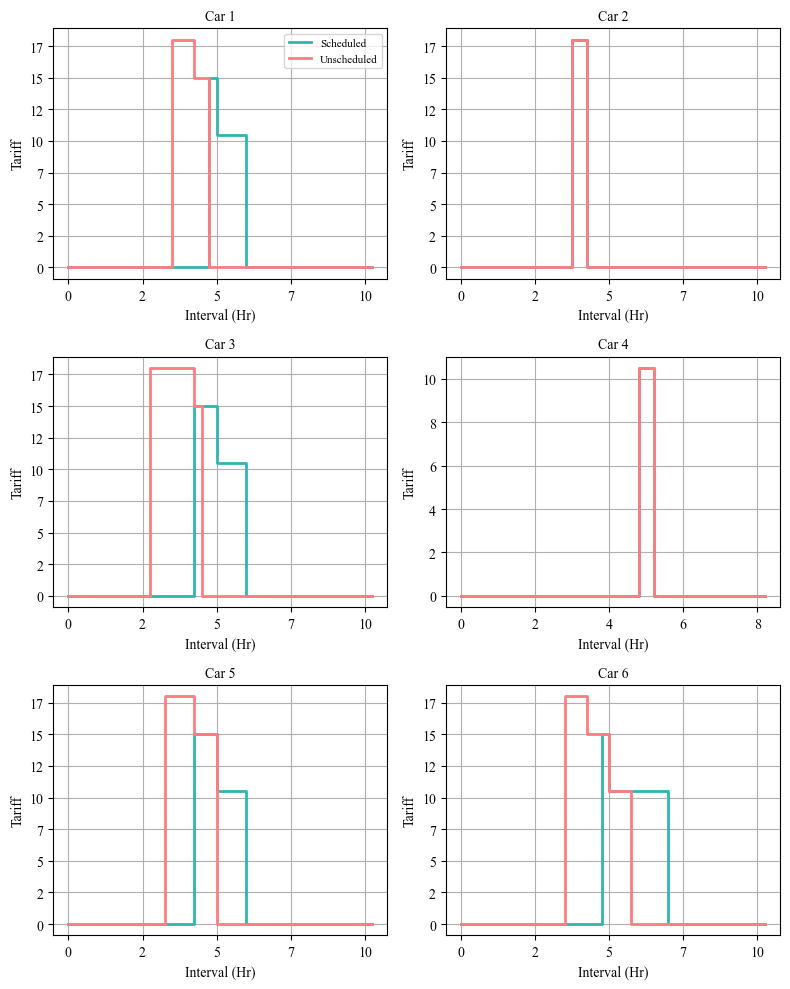

In [9]:
modified_scheduled_start_end = [(start, end + 24 if end < start else end) for start, end in scheduled_start_end]
modified_unscheduled_start_end = [(start, end + 24 if end < start else end) for start, end in unscheduled_start_end]

x_axis = list(range(1,24))+list(range(1,20))
x = np.arange(len(x_axis))

# Create a figure with 3 rows and 2 columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))

# Iterate through each row and column
for i in range(len(scheduled_start_end)):
    start, end = modified_scheduled_start_end[i]
    start1, end1 = modified_unscheduled_start_end[i]

    # Create a list to represent the modified interval tariff data
    scheduled_tariff = []
    unscheduled_tariff = []

   # Loop through x_axis values
    for block in x:
        # Set the tariff for the  from 1 to 17 and from 22 to 24 as 0
        if block <= start or block > end:
            scheduled_tariff.append(0)
        else:
            # Extract the hourly tariff corresponding to the start and end indices (with modulo operation)
            scheduled_tariff.append(hourly_tariff_list[(block-1)% len(hourly_tariff_list)])


        if block <= start1 or block > end1:
            unscheduled_tariff.append(0)
        else:
            # Extract the hourly tariff corresponding to the start and end indices (with modulo operation)
            unscheduled_tariff.append(hourly_tariff_list[(block-1)% len(hourly_tariff_list)])
    
    row = i // 2  # Determine the row index based on iteration
    col = i % 2   # Determine the column index based on iteration
    ax = axes[row, col]
    
    # Plot scheduled and unscheduled charging tariffs
    ax.step(range(len(scheduled_tariff)), scheduled_tariff, where='post', color='#2FB5B0', label='Scheduled', linewidth=2)
    ax.step(range(len(unscheduled_tariff)), unscheduled_tariff, where='post', color='#FF7C80', label='Unscheduled', linewidth=2)
    
    font = {'fontname': 'Times New Roman', 'size': 10}
    ax.set_xlabel('Interval (Hr)', **font)
    ax.set_ylabel('Tariff', **font)
    ax.set_title(f'Car {car[i]}', **font)
    ax.grid(True)
    ax.set_xticklabels(ax.get_yticks().astype(int), **font)
    ax.set_yticklabels(ax.get_yticks().astype(int), **font)

   
     # Show legend only on the first plot
    if i == 0:
        legend = ax.legend(fontsize=8)
        for text in legend.get_texts():
            text.set_fontname("Times New Roman")
        
# Adjust the layout spacing between subplots and titles
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Added rect parameter to give more space for the main title


# Save the figure as an image file
output_file = "1 hour model - charging cost.png"
plt.savefig(output_file, dpi=500, bbox_inches='tight', pad_inches=0.5)  # Added pad_inches parameter
   

# Adjust layout spacing
plt.tight_layout()

# Show the figure
plt.show()

### SIMULATION AND ANALYSIS

In [10]:
#SIMULATION AND ANALYSIS

#Create input data table
input_data = {
    "Car": car,
    "Arrival Time": arrival_time,
    "Departure Time": departure_time,
    "Energy Requirement": energy_requirement,
    "Overnight charging": ["Yes" if d<a else "No" for d,a in zip(departure_time, arrival_time)]
}

input_data_df = pd.DataFrame(input_data)

# Export DataFrame to Excel
excel_filename = "car_data.xlsx"
input_data_df.to_excel(excel_filename, index=False)
print(input_data_df.to_string(index=False))

 Car  Arrival Time  Departure Time  Energy Requirement Overnight charging
   1            13              23                  35                 No
   2            14              16                  30                 No
   3            10              23                  21                 No
   4            23               4                  17                Yes
   5            12              23                  23                 No
   6            13               3                  28                Yes


In [11]:
# Create intermediate parameter for optimization process
intermediate_data = {
    "Car": car,
    "Dwell time": dwell_time,
    "Charge length": charge_length,
    "Charging power": charge_power,
    "High demand alert": high_demand_alert
}

intermediate_data_df = pd.DataFrame(intermediate_data)
intermediate_data_df['Flexible load'] = ["Yes" if cl < ct else "No" for cl,ct in zip(charge_length, dwell_time)]

# Export to excel file
intermediate_data_df.to_excel("intermediate_data.xlsx", index = False)
print(intermediate_data_df.to_string(index=False))

 Car  Dwell time  Charge length  Charging power High demand alert Flexible load
   1          10              5               7                No           Yes
   2           2              2              11               Yes            No
   3          13              7               3                No           Yes
   4           5              2               7                No           Yes
   5          11              7               3                No           Yes
   6          14              9               3                No           Yes


In [12]:
#Create fulfilment tables:
fulfillment_data = {
    "Car": car,
    "Required energy": energy_requirement,
    "Fulfilled energy": energy_fulfillment,
    "Fulfilment rate % ": energy_fulfillment_percentage,
}

fulfillment_data_df=pd.DataFrame(fulfillment_data)

# Export to excel file
fulfillment_data_df.to_excel("fulfillment_data.xlsx", index = False)
print(fulfillment_data_df.to_string(index=False))

 Car  Required energy  Fulfilled energy  Fulfilment rate % 
   1               35                35               100.0
   2               30                22                73.0
   3               21                21               100.0
   4               17                14                82.0
   5               23                21                91.0
   6               28                27                96.0


In [13]:
#Create output tables:
output_data = {
    "Car": car,
    "Start time": [start for start, end in scheduled_start_end],
    "End time": [end for start, end in scheduled_start_end],
    "Fulfilment rate % ": energy_fulfillment_percentage,
    "Charging cost": minimized_cost_list
    
}

output_data_df=pd.DataFrame(output_data)
                            
# Export to excel file                           
output_data_df.to_excel("output_data.xlsx", index = False)                         
print(output_data_df.to_string(index=False))

 Car  Start time  End time  Fulfilment rate %   Charging cost
   1          18        23               100.0           39.9
   2          14        16                73.0           39.6
   3          16        23               100.0           26.1
   4          23         1                82.0           14.7
   5          16        23                91.0           26.1
   6          18         3                96.0           29.7


In [14]:
# Cost comparison between scheduled vs unscheduling charging
cost_analysis_data = {
    "Car": car,
    "Optimal cost": minimized_cost_list,
    "Unoptimized cost": unscheduled_cost_list,
    "Cost saving%": [round((un-opt)/un*100,1) for un,opt in zip(unscheduled_cost_list, minimized_cost_list)]
}

cost_analysis_data_df = pd.DataFrame(cost_analysis_data)

# Export to excel file                           
cost_analysis_data_df.to_excel("cost_analysis_data.xlsx", index = False)  

print(cost_analysis_data_df.to_string(index=False))

 Car  Optimal cost  Unoptimized cost  Cost saving%
   1          39.9             58.80          32.1
   2          39.6             39.60           0.0
   3          26.1             36.90          29.3
   4          14.7             14.70           0.0
   5          26.1             35.10          25.6
   6          29.7             39.15          24.1


In [15]:
# Cost comparison between scheduled vs unscheduling charging
cost_analysis_data = {
    "Car": car,
    "Optimal cost": [round(m, 1) for m in minimized_cost_list],
    "Unoptimized cost":[round(u, 1) for u in unscheduled_cost_list],
    "Cost saving%": [round((un-opt)/un*100,1) for un,opt in zip(unscheduled_cost_list, minimized_cost_list)]
    
}
cost_analysis_data_df=pd.DataFrame(cost_analysis_data)

# Export to excel file                           
cost_analysis_data_df.to_excel("cost_analysis_data2.xlsx", index = False) 

print(cost_analysis_data_df.to_string(index=False))

 Car  Optimal cost  Unoptimized cost  Cost saving%
   1          39.9              58.8          32.1
   2          39.6              39.6           0.0
   3          26.1              36.9          29.3
   4          14.7              14.7           0.0
   5          26.1              35.1          25.6
   6          29.7              39.1          24.1
